In [1]:
import numpy as np
from numpy.random import shuffle

import matplotlib.pyplot as plt
import wfdb
from pathlib import Path
import math
from math import floor
import cv2
import pywt
from functools import partial
from collections import defaultdict
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from numba import njit
from tqdm import tqdm
from time import time
import tsfresh
import tsfel
import pickle as pkl
import pandas as pd
import traceback
import sys
import gc

import sklearn
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, Normalizer, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

import scipy
from scipy import signal
from scipy.stats import kendalltau

import torch
from torch.optim.lr_scheduler import StepLR
from torch.backends import cudnn
import torch.nn.functional as F

import skorch
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring, Initializer, LRScheduler, TensorBoard, Checkpoint, Initializer
from skorch.dataset import Dataset

cudnn.benchmark = False
cudnn.deterministic = True

DEVICE = 'cuda'

print(f"Using device {DEVICE}!")

Using device cuda!


# Data processing

In [2]:
label_mapping = {
    "N": 0, "L": 0, "R": 0, "e": 0, "j": 0,  # N
    "A": 1, "a": 1, "S": 1, "J": 1,  # SVEB
    "V": 2, "E": 2,  # VEB
    "F": 3,  # F
    "/": 4, "f": 4, "Q": 4  # Q
}

@njit(parallel=True)
def njit_dtw(s1, s2):
    mat_d = np.ones((len(s1) + 1, len(s2) + 1)) * np.Inf
    mat_d[0, 0] = 0
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            d = (s1[i - 1] - s2[j - 1])**2
            mat_d[i, j] = d + min((mat_d[i-1, j], mat_d[i, j-1], mat_d[i-1, j-1]))
    return np.sqrt(mat_d[len(s1), len(s2)])


def read_ecg_data(path, record, lead, cwt_freqs=100):
    data = wfdb.rdsamp(str(path / str(record)))
    annotations = wfdb.rdann(str(path / str(record)), extension='atr')
    
    sampling_rate = data[1]['fs']
    try:
        lead_id = data[1]['sig_name'].index(lead)
    except ValueError:
        return None
    
    X = data[0][:, lead_id]

    baseline = signal.medfilt(signal.medfilt(X, int(0.2 * sampling_rate) - 1), int(0.6 * sampling_rate) - 1)
    X -= baseline
    
    y = np.asarray(annotations.symbol)
    loc = np.asarray(annotations.sample)

    indices = [i for i, label in enumerate(y) if label in label_mapping.keys()]
    y, loc = y[indices], loc[indices]

    tol = 0.05
    new_locs = []
    for r in loc:
        r_left = np.maximum(r - int(tol * sampling_rate), 0)
        r_right = np.minimum(r + int(tol * sampling_rate), len(X))
        new_locs.append(r_left + np.argmax(X[r_left:r_right]))
    loc = np.array(new_locs, dtype='int')

    X = X / np.mean(X[loc])

    y = np.asarray([label_mapping[l] for l in y])
    
    scales = pywt.central_frequency('mexh') * sampling_rate / np.arange(1, cwt_freqs + 1, 1)
    X_cwt, _ = pywt.cwt(X, scales, 'mexh', 1 / sampling_rate)
    return X, X_cwt, np.asarray(y), np.asarray(loc)


def get_rr_data(loc):
    loc = loc.astype(np.float32)
    avg_rr = np.mean(np.diff(loc))
    prev_rr = []
    next_rr = []
    ratio_rr = []
    local_rr = []
    for i in range(1, len(loc) - 1):
            prev_rr.append(loc[i] - loc[i - 1] - avg_rr)
            next_rr.append(loc[i + 1] - loc[i] - avg_rr)
            ratio_rr.append((loc[i] - loc[i - 1]) / (loc[i + 1] - loc[i]))
            local_rr.append(np.mean(np.diff(loc[np.maximum(i - 10, 0):i + 1])) - avg_rr)
    return np.asarray(prev_rr), np.asarray(next_rr), np.asarray(local_rr), np.asarray(ratio_rr)


def load_dataset(path, record_ids, lead='MLII', sampling_rate=360, n_before=90, n_after=110, cwt_freqs=100, n_windows=1, long_term_window=None):
    X_windows = []
    lt_windows = []
    X_cwt_windows = []
    rr_windows = []
    y_windows = []

    n_before = int(n_before * (sampling_rate / 360))
    n_after = int(n_after * (sampling_rate / 360))
    n_total = n_before + n_after

    if long_term_window is not None:
        long_term_window = sampling_rate * long_term_window
    
    for record in record_ids:
        X, X_cwt, y, loc = read_ecg_data(path, record, lead, cwt_freqs=cwt_freqs)
        prev_rr, next_rr, local_rr, ratio_rr = get_rr_data(loc)
        y = y[1:-1]
        loc = loc[1:-1]
        
        for i, (rpeak, label) in enumerate(zip(loc, y)):
            if n_windows > 1:
                if i >= n_windows // 2 and i < len(loc) - n_windows // 2:
                    windows = []
                    cwt_windows = []
                    for j in range(i - n_windows // 2, i + n_windows // 2 + 1):
                        rpeak, label = loc[j], y[j]
                        window = X[rpeak - n_before: rpeak + n_after]
                        cwt_window = cv2.resize(X_cwt[:, rpeak - n_before:rpeak + n_after], (n_total // 2, cwt_freqs))
                        if len(window) == n_total:
                            windows.append(window)
                            cwt_windows.append(cwt_window)
                    if len(windows) == n_windows:
                        X_windows.append(windows[n_windows // 2])
                        X_cwt_windows.append(np.stack(cwt_windows))
                        rr_windows.append([prev_rr[i], next_rr[i], local_rr[i], ratio_rr[i]])
                        y_windows.append([label, record])
            else:
                window = X[rpeak - n_before:rpeak + n_after]

                lt_window = None
                if long_term_window and rpeak > long_term_window // 2 and rpeak + long_term_window // 2 < len(X):
                    lt_window = X[rpeak - long_term_window // 2: rpeak + long_term_window // 2]
    
                if len(window) == n_total and (long_term_window is not None and lt_window is not None):
                    X_windows.append(window)
                    lt_windows.append(lt_window)
                    X_cwt_windows.append(cv2.resize(X_cwt[:, rpeak - n_before:rpeak + n_after], (n_total // 2, cwt_freqs)))
                    rr_windows.append([prev_rr[i], next_rr[i], local_rr[i], ratio_rr[i]])
                    y_windows.append([label, record])
            
    return np.asarray(X_windows), np.asarray(lt_windows), np.asarray(X_cwt_windows), np.asarray(rr_windows), np.asarray(y_windows)

## MIT-BIH supraventricular processing

In [88]:
data_root = Path('data/mit-bih-supraventricular-arrhythmia-database-1.0.0/')

label_mapping = {
    'N': 'N',
    'L': 'N',
    'R': 'N',
    'B': 'N',
    'A': 'S',
    'a': 'S',
    'x': 'S',
    'J': 'S',
    'V': 'V',
    'F': 'F',
    '!': 'V',
    'e': 'N',
    'j': 'N',
    'E': 'V',
#     'f': 'Q',
#     'Q': 'Q',
}

label_categories = set(label_mapping.values())

label_to_num = {k: float(i) for i, k in enumerate(label_categories)}
num_to_label = {v: k for k, v in label_to_num.items()}
sampling_rate = 128
lead_id = 'ECG2'

patient_ids = list(set([f.stem for f in data_root.glob('*') if f.stem.isnumeric()]))
training_ids, testing_ids = train_test_split(patient_ids, train_size=.5, random_state=755)

In [89]:
X, X_local, X_cwt, rr_information, y = load_dataset(data_root, training_ids, lead=lead_id, sampling_rate=sampling_rate)
np.save(Path('processed_data/mit-bih-supra/X_train'), X)
np.save(Path('processed_data/mit-bih-supra/X_local_train'), X_local)
np.save(Path('processed_data/mit-bih-supra/X_cwt_train'), X_cwt)
np.save(Path('processed_data/mit-bih-supra/rr_train'), rr_information)
np.save(Path('processed_data/mit-bih-supra/y_train'), y)

X.shape, X_local.shape, X_cwt.shape, rr_information.shape, y.shape

((89606, 71), (89606, 71), (89606, 100, 100), (89606, 4), (89606, 2))

In [90]:
X, X_local, X_cwt, rr_information, y = load_dataset(data_root, testing_ids, lead=lead_id, sampling_rate=sampling_rate)

np.save(Path('processed_data/mit-bih-supra/X_test'), X)
np.save(Path('processed_data/mit-bih-supra/X_local_test'), X_local)
np.save(Path('processed_data/mit-bih-supra/X_cwt_test'), X_cwt)
np.save(Path('processed_data/mit-bih-supra/rr_test'), rr_information)
np.save(Path('processed_data/mit-bih-supra/y_test'), y)

X.shape, X_local.shape, X_cwt.shape, rr_information.shape, y.shape

((93817, 71), (93817, 71), (93817, 100, 100), (93817, 4), (93817, 2))

## INCART processing

In [102]:
data_root = Path('data/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0/files')

patient_mapping = {
    1: ['I01', 'I02'],
    2: ['I03', 'I04', 'I05'],
    3: ['I06', 'I07'],
    4: ['I08'],
    5: ['I09', 'I10', 'I11'],
    6: ['I12', 'I13', 'I14'],
    7: ['I15'],
    8: ['I16', 'I17'],
    9: ['I18', 'I19'],
    10: ['I20', 'I21', 'I22'],
    11: ['I23', 'I24'],
    12: ['I25', 'I26'],
    13: ['I27', 'I28'],
    14: ['I29', 'I30', 'I31', 'I32'],
    15: ['I33', 'I34'],
    16: ['I35', 'I36', 'I37'],
    17: ['I38', 'I39'],
    18: ['I40', 'I41'],
    19: ['I42', 'I43'],
    20: ['I44', 'I45', 'I46'],
    21: ['I47', 'I48'],
    22: ['I49', 'I50'],
    23: ['I51', 'I52', 'I53'],
    24: ['I54', 'I55', 'I56'],
    25: ['I57', 'I58'],
    26: ['I59', 'I60', 'I61'],
    27: ['I62', 'I63', 'I64'],
    28: ['I65', 'I66', 'I67'],
    29: ['I68', 'I69'],
    30: ['I70', 'I71'],
    31: ['I72', 'I73'],
    32: ['I74', 'I75']
}

label_mapping = {
    'N': 'N',
    'V': 'V',
    'A': 'S',
    'j': 'N',
    'F': 'F',
    'S': 'S',
    'n': 'S',
    'B': 'N',
    'R': 'N',
    'Q': 'Q'
}

label_categories = set(label_mapping.values())

label_to_num = {k: float(i) for i, k in enumerate(label_categories)}
num_to_label = {v: k for k, v in label_to_num.items()}

sampling_rate = 257
lead_id = 'II'

training_patients, testing_patients = train_test_split(list(patient_mapping.keys()), train_size=.5, random_state=755)
training_ids = np.concatenate([[f for f in patient_mapping[p]] for p in training_patients]).tolist()
testing_ids = np.concatenate([[f for f in patient_mapping[p]] for p in testing_patients]).tolist()

In [106]:
X, X_local, X_cwt, rr_information, y = load_dataset(data_root, training_ids, lead=lead_id, sampling_rate=sampling_rate)

np.save(Path('processed_data/incar/X_train'), X)
np.save(Path('processed_data/incar/X_local_train'), X_local)
np.save(Path('processed_data/incar/X_cwt_train'), X_cwt)
np.save(Path('processed_data/incar/rr_train'), rr_information)
np.save(Path('processed_data/incar/y_train'), y)

X.shape, X_local.shape, X_cwt.shape, rr_information.shape, y.shape

((93714, 142), (93714, 142), (93714, 100, 100), (93714, 4), (93714, 2))

In [107]:
X, X_local, X_cwt, rr_information, y = load_dataset(data_root, testing_ids, lead=lead_id, sampling_rate=sampling_rate)

np.save(Path('processed_data/incar/X_test'), X)
np.save(Path('processed_data/incar/X_local_test'), X_local)
np.save(Path('processed_data/incar/X_cwt_test'), X_cwt)
np.save(Path('processed_data/incar/rr_test'), rr_information)
np.save(Path('processed_data/incar/y_test'), y)

X.shape, X_local.shape, X_cwt.shape, rr_information.shape, y.shape

((81093, 142), (81093, 142), (81093, 100, 100), (81093, 4), (81093, 2))

## MIT BIH processing

In [3]:
data_root = Path('/data/IDLab/DigiHealth/mit-bih-arrhythmia-database-1.0.0/')

training_ids = [
    101, 106, 108, 109, 112,
    114, 115, 116, 118, 119,
    122, 124, 201, 203, 205,
    207, 208, 209, 215, 220,
    223, 230
]
testing_ids = [
    100, 103, 105, 111, 113,
    117, 121, 123, 200, 202,
    210, 212, 213, 214, 219,
    221, 222, 228, 231, 232,
    233, 234
]

sampling_rate = 360

In [15]:
X, X_lt, X_cwt, rr_information, y = load_dataset(data_root, training_ids, long_term_window=10)
np.save(Path('processed_data/mit-bih/X_train'), X)
np.save(Path('processed_data/mit-bih/X_cwt_train'), X_cwt)
np.save(Path('processed_data/mit-bih/rr_train'), rr_information)
np.save(Path('processed_data/mit-bih/y_train'), y)

features_dict = tsfel.get_features_by_domain()
X_feat = tsfel.time_series_features_extractor(features_dict, np.concatenate(X), fs=sampling_rate, window_size=X.shape[-1])
X_feat.to_csv(Path('processed_data/mit-bih/X_feat_train.csv'), index=False)

X_lt_feat = tsfel.time_series_features_extractor(features_dict, np.concatenate(X_lt), fs=sampling_rate, window_size=X_lt.shape[-1])
X_lt_feat.to_csv(Path('processed_data/mit-bih/X_lt_feat_train.csv'), index=False)

X.shape, X_lt.shape, X_cwt.shape, rr_information.shape, X_feat.shape, X_lt_feat.shape, y.shape

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
X_feat = pd.read_csv(Path('processed_data/mit-bih/X_feat_train.csv'))
X_lt_feat = pd.read_csv(Path('processed_data/mit-bih/X_lt_feat_train.csv'))
y = np.load(Path('processed_data/mit-bih/y_train.npy'))[:, 0]

tau_vals = sorted([(feat, (result.pvalue, -abs(result.statistic))) for feat, result in [(feat, kendalltau(X_feat[feat], y)) for feat in X_feat.columns]], key=lambda r: r[1])
sorted_features = [feat for feat, _ in tau_vals]
X_feat = X_feat[sorted_features].values
sorted_features = np.asarray(sorted_features)

tau_lt_vals = sorted([(feat, (result.pvalue, -abs(result.statistic))) for feat, result in [(feat, kendalltau(X_lt_feat[feat], y)) for feat in X_lt_feat.columns]], key=lambda r: r[1])
sorted_lt_features = [feat for feat, _ in tau_lt_vals]
X_lt_feat = X_lt_feat[sorted_lt_features].values
sorted_lt_features = np.asarray(sorted_lt_features)

np.save(Path('processed_data/mit-bih/X_feat_train'), X_feat)
np.save(Path('processed_data/mit-bih/X_lt_feat_train'), X_lt_feat)
np.save(Path('processed_data/mit-bih/sorted_features'), sorted_features)
np.save(Path('processed_data/mit-bih/sorted_lt_features'), sorted_lt_features)

In [20]:
X, X_lt, X_cwt, rr_information, y = load_dataset(data_root, testing_ids, long_term_window=10)

np.save(Path('processed_data/mit-bih/X_test'), X)
np.save(Path('processed_data/mit-bih/X_cwt_test'), X_cwt)
np.save(Path('processed_data/mit-bih/rr_test'), rr_information)
np.save(Path('processed_data/mit-bih/y_test'), y)

features_dict = tsfel.get_features_by_domain()
X_feat = tsfel.time_series_features_extractor(features_dict, np.concatenate(X), fs=sampling_rate, window_size=X.shape[-1])
X_feat.to_csv(Path('processed_data/mit-bih/X_feat_test.csv'), index=False)

X_lt_feat = tsfel.time_series_features_extractor(features_dict, np.concatenate(X_lt), fs=sampling_rate, window_size=X_lt.shape[-1])
X_lt_feat.to_csv(Path('processed_data/mit-bih/X_lt_feat_test.csv'), index=False)

X.shape, X_lt.shape, X_cwt.shape, rr_information.shape, X_feat.shape, X_lt_feat.shape, y.shape

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


((49434, 200),
 (49434, 3600),
 (49434, 100, 100),
 (49434, 4),
 (49434, 234),
 (49434, 389),
 (49434, 2))

In [23]:
X_feat = pd.read_csv(Path('processed_data/mit-bih/X_feat_test.csv'))
X_lt_feat = pd.read_csv(Path('processed_data/mit-bih/X_lt_feat_test.csv'))
y = np.load(Path('processed_data/mit-bih/y_test.npy'))
sorted_features = np.load(Path('processed_data/mit-bih/sorted_features.npy')).tolist()
sorted_lt_features = np.load(Path('processed_data/mit-bih/sorted_lt_features.npy')).tolist()

X_feat = X_feat[sorted_features].values
X_lt_feat = X_lt_feat[sorted_lt_features].values

np.save(Path('processed_data/mit-bih/X_feat_test'), X_feat)
np.save(Path('processed_data/mit-bih/X_lt_feat_test'), X_lt_feat)

## Combine datasets

In [6]:
def resample_dataset(dataset_id, new_size, new_sampling_rate):
    X_train = np.load(Path(f"processed_data/{dataset_id}/X_train.npy"))
    rr_train = np.load(Path(f"processed_data/{dataset_id}/rr_train.npy"))
    y_train = np.load(Path(f"processed_data/{dataset_id}/y_train.npy"))
    
    X_test = np.load(Path(f"processed_data/{dataset_id}/X_test.npy"))
    rr_test = np.load(Path(f"processed_data/{dataset_id}/rr_test.npy"))
    y_test = np.load(Path(f"processed_data/{dataset_id}/y_test.npy"))

    print(X_train.shape)
    X_train = scipy.signal.resample(X_train, new_size, axis=-1)
    print(X_train.shape)
    X_test = scipy.signal.resample(X_test, new_size, axis=-1)

    new_dataset_id = dataset_id + f"-{new_sampling_rate}Hz"
    dataset_path = Path('processed_data') / new_dataset_id
    dataset_path.mkdir(exist_ok=True)
    
    np.save(dataset_path / 'X_train', X_train)
    np.save(dataset_path / 'rr_train', rr_train)
    np.save(dataset_path / 'y_train', y_train)
    
    np.save(dataset_path / 'X_test', X_test)
    np.save(dataset_path / 'rr_test', rr_test)
    np.save(dataset_path / 'y_test', y_test)

### Resample datasets

In [7]:
resample_dataset('incar', new_size=71, new_sampling_rate=128)

(93714, 142)
(93714, 71)


In [8]:
resample_dataset('mit-bih', new_size=71, new_sampling_rate=128)

(52272, 200)
(52272, 71)


### Combine datasets

In [26]:
datasets = [Path('processed_data') / ds for ds in ['incar-128Hz', 'mit-bih-128Hz', 'mit-bih-supra']]

label_mapping = {
    'N': 'N',
    'L': 'N',
    'R': 'N',
    'B': 'N',
    'A': 'S',
    'a': 'S',
    'x': 'S',
    'J': 'S',
    'V': 'V',
    #'F': 'F',
    '!': 'V',
    'e': 'N',
    'j': 'N',
    'E': 'V',
    'S': 'S',
    'n': 'S',
    'J': 'S',
}
label_categories = set(label_mapping.values())
label_to_num = {k: float(i) for i, k in enumerate(label_categories)}
num_to_label = {v: k for k, v in label_to_num.items()}

X_train = []
rr_train = []
y_train = []
X_test = []
rr_test = []
y_test = []
for ds_path in datasets:
    X_train.append(np.load(ds_path / 'X_train.npy'))
    rr_train.append(np.load(ds_path / 'rr_train.npy'))
    y_train.append(np.load(ds_path / 'y_train.npy'))

    X_test.append(np.load(ds_path / 'X_test.npy'))
    rr_test.append(np.load(ds_path / 'rr_test.npy'))
    y_test.append(np.load(ds_path / 'y_test.npy'))

X_train = np.concatenate(X_train)
rr_train = np.concatenate(rr_train)
y_train = np.concatenate(y_train)

X_test = np.concatenate(X_test)
rr_test = np.concatenate(rr_test)
y_test = np.concatenate(y_test)

X_train = np.asarray([w for w, l in zip(X_train, y_train) if l[0] in label_mapping]).astype(np.float32)
rr_train = np.asarray([w for w, l in zip(rr_train, y_train) if l[0] in label_mapping]).astype(np.float32)
y_train = y_train[:, 0]
y_train = np.asarray([label_mapping[l] for l in y_train if l in label_mapping])

X_test = np.asarray([w for w, l in zip(X_test, y_test) if l[0] in label_mapping]).astype(np.float32)
rr_test = np.asarray([w for w, l in zip(rr_test, y_test) if l[0] in label_mapping]).astype(np.float32)
y_test = y_test[:, 0]
y_test = np.asarray([label_mapping[l] for l in y_test if l in label_mapping])

X_train.shape, X_test.shape, np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((233983, 71),
 (224023, 71),
 (array(['N', 'S', 'V'], dtype='<U1'), array([207047,   6215,  20721])),
 (array(['N', 'S', 'V'], dtype='<U1'), array([196634,  10870,  16519])))

In [27]:
np.save(Path('processed_data/combined/X_train'), X_train)
np.save(Path('processed_data/combined/rr_train'), rr_train)
np.save(Path('processed_data/combined/y_train'), y_train)

np.save(Path('processed_data/combined/X_test'), X_test)
np.save(Path('processed_data/combined/rr_test'), rr_test)
np.save(Path('processed_data/combined/y_test'), y_test)

# Supervised learning

## Baseset load

In [4]:
dataset_id = 'mit-bih'

allowed_labels = [0, 2, 1]
num_to_label = {0: 'N', 1: 'S', 2: 'V', 3: 'F'}

#X_train = np.load(Path(f"processed_data/{dataset_id}/X_train.npy"))
X_cwt_train = np.load(Path(f"processed_data/{dataset_id}/X_cwt_train.npy")).astype(np.float32)
X_feat_train = np.load(Path(f"processed_data/{dataset_id}/X_feat_train.npy")).astype(np.float32)
X_lt_feat_train = np.load(Path(f"processed_data/{dataset_id}/X_lt_feat_train.npy")).astype(np.float32)
rr_train = np.load(Path(f"processed_data/{dataset_id}/rr_train.npy")).astype(np.float32)
y_train = np.load(Path(f"processed_data/{dataset_id}/y_train.npy"))

#X_test = np.load(Path(f"processed_data/{dataset_id}/X_test.npy"))
X_cwt_test = np.load(Path(f"processed_data/{dataset_id}/X_cwt_test.npy")).astype(np.float32)
X_feat_test = np.load(Path(f"processed_data/{dataset_id}/X_feat_test.npy")).astype(np.float32)
X_lt_feat_test = np.load(Path(f"processed_data/{dataset_id}/X_lt_feat_test.npy")).astype(np.float32)
rr_test = np.load(Path(f"processed_data/{dataset_id}/rr_test.npy")).astype(np.float32)
y_test = np.load(Path(f"processed_data/{dataset_id}/y_test.npy"))

#X_train = np.asarray([w for w, l in zip(X_train, y_train) if l[0] in allowed_labels]).astype(np.float32)
X_cwt_train_filtered = np.asarray([w for w, l in zip(X_cwt_train, y_train) if l[0] in allowed_labels])
X_feat_train_filtered = np.asarray([w for w, l in zip(X_feat_train, y_train) if l[0] in allowed_labels])
X_lt_feat_train_filtered = np.asarray([w for w, l in zip(X_lt_feat_train, y_train) if l[0] in allowed_labels])
rr_train_filtered = np.asarray([w for w, l in zip(rr_train, y_train) if l[0] in allowed_labels])
y_train_filtered = y_train[:, 0]
y_train_filtered = np.asarray([l for l in y_train_filtered if l in allowed_labels]).astype(np.int64)

del X_cwt_train, X_feat_train, X_lt_feat_train, rr_train, y_train
gc.collect()
X_cwt_train = X_cwt_train_filtered
X_feat_train = X_feat_train_filtered
X_lt_feat_train = X_lt_feat_train_filtered
rr_train = rr_train_filtered
y_train = y_train_filtered

#X_test = np.asarray([w for w, l in zip(X_test, y_test) if l[0] in allowed_labels]).astype(np.float32)
X_cwt_test_filtered = np.asarray([w for w, l in zip(X_cwt_test, y_test) if l[0] in allowed_labels])
X_feat_test_filtered = np.asarray([w for w, l in zip(X_feat_test, y_test) if l[0] in allowed_labels])
X_lt_feat_test_filtered = np.asarray([w for w, l in zip(X_lt_feat_test, y_test) if l[0] in allowed_labels])
rr_test_filtered = np.asarray([w for w, l in zip(rr_test, y_test) if l[0] in allowed_labels])
y_test_filtered = y_test[:, 0]
y_test_filtered = np.asarray([l for l in y_test_filtered if l in allowed_labels]).astype(np.int64)

del X_cwt_test, X_feat_test, X_lt_feat_test, rr_test, y_test
gc.collect()
X_cwt_test = X_cwt_test_filtered
X_feat_test = X_feat_test_filtered
X_lt_feat_test = X_lt_feat_test_filtered
rr_test = rr_test_filtered
y_test = y_test_filtered

# ecg_scaler = MinMaxScaler()
# X_train = ecg_scaler.fit_transform(X_train)
# X_test = ecg_scaler.transform(X_test)

rr_scaler = RobustScaler()
rr_train = rr_scaler.fit_transform(rr_train)
rr_test = rr_scaler.transform(rr_test)

feat_scaler = RobustScaler()
X_feat_train = feat_scaler.fit_transform(X_feat_train)
X_feat_test = feat_scaler.transform(X_feat_test)

lt_feat_scaler = RobustScaler()
X_lt_feat_train = feat_scaler.fit_transform(X_lt_feat_train)
X_lt_feat_test = feat_scaler.transform(X_lt_feat_test)

X_cwt_train.shape, X_cwt_test.shape

((50319, 100, 100), (49039, 100, 100))

## Full load

In [28]:
dataset_id = 'combined'

label_to_num = {'N': 0, 'S': 1, 'V': 2}
num_to_label = {v: k for k, v in label_to_num.items()}

X_train = np.load(Path(f"processed_data/{dataset_id}/X_train.npy"))
rr_train = np.load(Path(f"processed_data/{dataset_id}/rr_train.npy"))
y_train = np.load(Path(f"processed_data/{dataset_id}/y_train.npy"))
y_train = np.asarray([label_to_num[l] for l in y_train]).astype(np.int64)

X_test = np.load(Path(f"processed_data/{dataset_id}/X_test.npy"))
rr_test = np.load(Path(f"processed_data/{dataset_id}/rr_test.npy"))
y_test = np.load(Path(f"processed_data/{dataset_id}/y_test.npy"))
y_test = np.asarray([label_to_num[l] for l in y_test]).astype(np.int64)

In [34]:
sampler = RandomUnderSampler(random_state=7665)
X_train, _ = sampler.fit_resample(X_train, y_train)
rr_train, y_train = sampler.fit_resample(rr_train, y_train)

## Data exploration

In [150]:
train_labels, train_counts = np.unique(y_train[y_train[:, 0] == 'F'][:, 1], return_counts=True)
test_labels, test_counts = np.unique(y_test[y_test[:, 0] == 'F'][:, 1], return_counts=True)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(len(train_labels) + len(test_labels)), np.concatenate([train_counts, test_counts]))
plt.xticks(np.arange(len(train_labels) + len(test_labels)), np.concatenate([train_labels, test_labels]))
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [151]:
training_beats = X_train[(y_train[:, 0] == 'F') & (y_train[:, 1] == '208')]
testing_beats = X_test[(y_test[:, 0] == 'F') & (y_test[:, 1] == '213')]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True)

axs[0].plot(training_beats.T, color='b', alpha=.01)
axs[0].set_title('Patient 208')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].plot(testing_beats.T, color='orange', alpha=.01)
axs[1].set_title('Patient 213')

plt.tight_layout()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

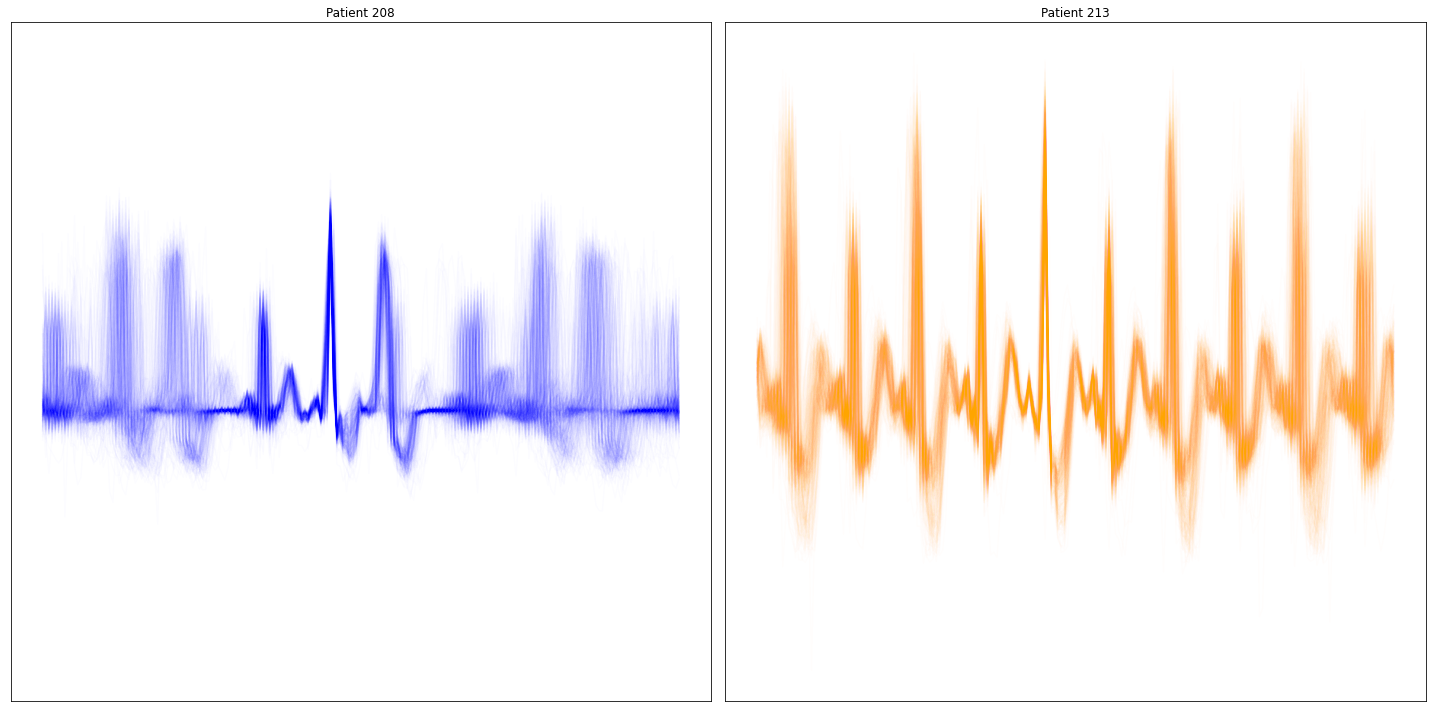

In [67]:
training_local_beats = X_local_train[(y_train[:, 0] == 'F') & (y_train[:, 1] == '208')]
testing_local_beats = X_local_test[(y_test[:, 0] == 'F') & (y_test[:, 1] == '213')]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True)

axs[0].plot(training_local_beats.T, color='b', alpha=.01)
axs[0].set_title('Patient 208')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].plot(testing_local_beats.T, color='orange', alpha=.01)
axs[1].set_title('Patient 213')

plt.tight_layout()
plt.show()

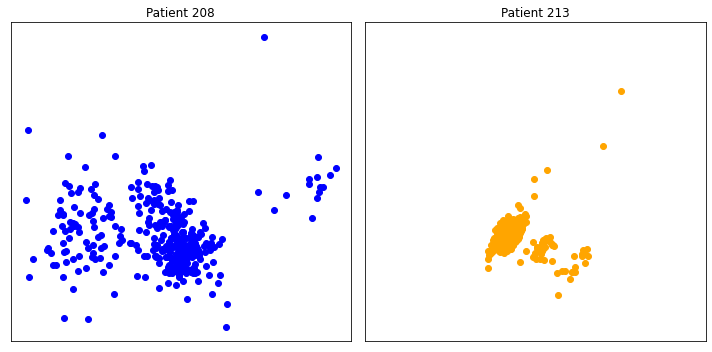

In [72]:
training_rr = rr_train[(y_train[:, 0] == 'F') & (y_train[:, 1] == '208')]
testing_rr = rr_test[(y_test[:, 0] == 'F') & (y_test[:, 1] == '213')]

pca = PCA(n_components=2)
training_pca = pca.fit_transform(training_rr)

pca = PCA(n_components=2)
testing_pca = pca.fit_transform(testing_rr)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)

axs[0].scatter(training_pca[:, 0], training_pca[:, 1], color='b')
axs[0].set_title('Patient 208')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].scatter(testing_pca[:, 0], testing_pca[:, 1], color='orange')
axs[1].set_title('Patient 213')

plt.tight_layout()
plt.show()

## Resampling

In [73]:
sm = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
sm = SMOTE(random_state=123)
X_local_train_resampled, _ = sm.fit_resample(X_local_train, y_train)
sm = SMOTE(random_state=123)
rr_train_resampled, _ = sm.fit_resample(rr_train, y_train)

In [7]:
training_patients = np.unique(y_train[:, 1])
X_train_resampled = []
X_local_train_resampled = []
rr_train_resampled = []
y_train_resampled = []
for patient_id in training_patients:
    indices = y_train[:, 1] == patient_id
    X, X_local, rr, y = X_train[indices], X_local_train[indices], rr_train[indices], y_train[indices, 0]
    
    if np.unique(y).shape[0] > 1:
        resampler = RandomOverSampler(random_state=123)
        X, _ = resampler.fit_resample(X, y)
        resampler = RandomOverSampler(random_state=123)
        X_local, _ = resampler.fit_resample(X_local, y)
        resampler = RandomOverSampler(random_state=123)
        rr, y = resampler.fit_resample(rr, y)
        
        X_train_resampled.append(X)
        X_local_train_resampled.append(X_local)
        rr_train_resampled.append(rr)
        y_train_resampled.append(y)
        
X_train_resampled = np.concatenate(X_train_resampled)
X_local_train_resampled = np.concatenate(X_local_train_resampled)
rr_train_resampled = np.concatenate(rr_train_resampled)
y_train_resampled = np.concatenate(y_train_resampled).astype(np.float64)

In [24]:
std = .00

X_train = X_train_resampled + std * np.random.randn(*X_train_resampled.shape).astype(np.float32)
X_local_train = X_local_train_resampled + std * np.random.randn(*X_local_train_resampled.shape).astype(np.float32)
rr_train = rr_train_resampled + std * np.random.randn(*rr_train_resampled.shape).astype(np.float32)
y_train = y_train_resampled.astype(np.int64)
#y_test = y_test[:, 0].astype(np.float64).astype(np.int64)

## Evaluation

In [25]:
class CNN2D(torch.nn.Module):
    def __init__weights(w):
        if isinstance(w, torch.nn.Linear) or isinstance(w, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(w.weight)
            torch.nn.init.constant_(w.bias, val=0.0)
    
    def __init__(self, n_features=0, n_lt_features=0, lrelu_slope=.2):
        super(CNN2D, self).__init__()
        self.n_classes = len(allowed_labels)
        self.lrelu_slope = lrelu_slope
        self.n_features = n_features
        self.n_lt_features = n_lt_features
        self.feature_head_output = 64 if (n_features != 0 or n_lt_features != 0) else 4
        self.beat_head = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(self.lrelu_slope),
            torch.nn.MaxPool2d(5),
            
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(self.lrelu_slope),
            torch.nn.MaxPool2d(3),
            
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(self.lrelu_slope),
            torch.nn.AdaptiveMaxPool2d((1, 1)),
            
            torch.nn.Flatten()
        ).to(DEVICE)

        self.feature_head = torch.nn.Sequential(
            torch.nn.Linear(4 + self.n_features + self.n_lt_features, 128),
            torch.nn.LeakyReLU(self.lrelu_slope),
            torch.nn.Linear(128, 128),
            torch.nn.LeakyReLU(self.lrelu_slope),
            torch.nn.Linear(128, self.feature_head_output),
            torch.nn.LeakyReLU(self.lrelu_slope),
        ).to(DEVICE)
        
        self.linear_blocks = torch.nn.Sequential(
            torch.nn.Linear(64 + self.feature_head_output, 256),
            torch.nn.LeakyReLU(self.lrelu_slope),
            torch.nn.Linear(256, 64),
            torch.nn.LeakyReLU(self.lrelu_slope),
            torch.nn.Linear(64, 32),
            torch.nn.LeakyReLU(self.lrelu_slope),
            torch.nn.Linear(32, self.n_classes)
        ).to(DEVICE)
        
        self.beat_head.apply(CNN2D.__init__weights)
        self.feature_head.apply(CNN2D.__init__weights)
        self.linear_blocks.apply(CNN2D.__init__weights)


    def forward(self, X, X_rr, X_feat=None, X_lt_feat=None):
        X = torch.unsqueeze(X, 1)
        if X_feat is not None:
            X_feat = torch.cat((X_rr, X_feat), dim=1)
        if X_lt_feat is not None:
            if X_feat is not None:
                X_feat = torch.cat((X_feat, X_lt_feat), dim=1)
            else:
                X_feat = torch.cat((X_rr, X_lt_feat), dim=1)
        
        z_beat = self.beat_head(X)
        if X_feat is not None:
            z_feat = self.feature_head(X_feat)
        else:
            z_feat = X_rr
        
        z = torch.cat((z_beat, z_feat), dim=1)

        return self.linear_blocks(z)


class CNNDeep2D(torch.nn.Module):
    def __init__weights(w):
        if isinstance(w, torch.nn.Linear) or isinstance(w, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(w.weight)
            torch.nn.init.constant_(w.bias, val=0.0)

    def __init__(self, n_features=0):
        super(CNNDeep2D, self).__init__()
        self.n_classes = len(allowed_labels)
        self.n_features = n_features
        self.feature_head_output = 32 if n_features != 0 else 4

        self.conv_block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=5, out_channels=64, kernel_size=7, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        ).to(DEVICE)
        self.conv_block_1.apply(CNNDeep2D.__init__weights)

        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same'),
            torch.nn.BatchNorm2d(64),
        ).to(DEVICE)
        self.conv_block_2.apply(CNNDeep2D.__init__weights)

        self.conv_block_3 = torch.nn.Sequential(
            torch.nn.MaxPool2d(4),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding='same'),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        ).to(DEVICE)
        self.conv_block_3.apply(CNNDeep2D.__init__weights)

        self.conv_block_4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding='same'),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding='same'),
            torch.nn.BatchNorm2d(128),
        ).to(DEVICE)
        self.conv_block_4.apply(CNNDeep2D.__init__weights)

        self.conv_block_5 = torch.nn.Sequential(
            torch.nn.MaxPool2d(5),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding='same'),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        ).to(DEVICE)
        self.conv_block_5.apply(CNNDeep2D.__init__weights)

        self.conv_block_6 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding='same'),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding='same'),
            torch.nn.BatchNorm2d(256),
        ).to(DEVICE)
        self.conv_block_6.apply(CNNDeep2D.__init__weights)

        self.flatten = torch.nn.Sequential(
            torch.nn.AdaptiveMaxPool2d((1, 1)),
            torch.nn.Flatten()
        )

        self.feature_head = torch.nn.Sequential(
            torch.nn.Linear(4 + self.n_features, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
        ).to(DEVICE)
        self.feature_head.apply(CNNDeep2D.__init__weights)
        
        self.linear_blocks = torch.nn.Sequential(
            torch.nn.Linear(256 + self.feature_head_output, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, self.n_classes)
        ).to(DEVICE)
        self.linear_blocks.apply(CNNDeep2D.__init__weights)

    
    def forward(self, X, X_rr, X_feat=None):
        if X_feat is not None:
            X_feat = torch.cat((X_rr, X_feat), dim=1)
        
        z_1 = self.conv_block_1(X)
        z_2 = F.relu(z_1 + self.conv_block_2(z_1))
        z_3 = self.conv_block_3(z_2)
        z_4 = F.relu(z_3 + self.conv_block_4(z_3))
        z_5 = self.conv_block_5(z_4)
        z_6 = F.relu(z_5 + self.conv_block_6(z_5))
        z_beat = self.flatten(z_6)
        
        if X_feat is not None:
            z_feat = self.feature_head(X_feat)
        else:
            z_feat = X_rr
        
        z = torch.cat((z_beat, z_feat), dim=1)

        return self.linear_blocks(z)


class CNN1D(torch.nn.Module):

    def __init__weights(w):
        if isinstance(w, torch.nn.Linear) or isinstance(w, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(w.weight)
            torch.nn.init.constant_(w.bias, val=0.0)
    
    def __init__(self, n_features=0):
        super(CNN1D, self).__init__()
        self.n_classes = len(allowed_labels)
        self.n_features = n_features
        self.beat_head = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7),
            torch.nn.BatchNorm1d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(5),
            
            torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(3),
            
            torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.AdaptiveMaxPool1d(1),
            
            torch.nn.Flatten()
        ).to(DEVICE)

        self.feature_block = torch.nn.Sequential(
            torch.nn.Linear(4 + self.n_features, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU()
        ).to(DEVICE)

        self.beat_head.apply(CNN1D.__init__weights)
        self.linear_blocks.apply(CNN1D.__init__weights)
        
        
    def forward(self, X, X_rr, X_feat=None):
        X = torch.unsqueeze(X, 1)
        
        z_beat = self.beat_head(X)
        
        z = torch.cat((z_beat, X_rr), dim=1)
        if X_feat is not None:
            z = torch.cat((z, X_feat), dim=1)

        return self.linear_blocks(z)


class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2., reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs => [batch_size, num_classes], targets => [batch_size]
        
        log_prob = F.log_softmax(inputs, dim=1)
        prob = torch.exp(log_prob)

        # Focal Loss formula
        loss = -1 * (1 - prob) ** self.gamma * log_prob

        # Apply class weights
        if self.alpha is not None:
            alpha = self.alpha[targets]
            loss = loss * alpha.unsqueeze(1)

        loss = torch.gather(loss, 1, targets.unsqueeze(1))

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


class MatrixWeightedCrossEntropy(torch.nn.Module):
    def __init__(self, weight_matrix, reduction='mean'):
        super(MatrixWeightedCrossEntropy, self).__init__()
        self.weight_matrix = weight_matrix
        self.reduction = reduction


    def forward(self, inputs, targets):
        loss = F.cross_entropy(inputs, targets, reduction='none')
        weights = self.weight_matrix[targets, torch.argmax(inputs, dim=1)]
        loss = loss * weights
    
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss

In [26]:
def train_and_evaluate_model(X_train, rr_train, y_train, X_test, rr_test, y_test,
                             X_feat_train=None, X_feat_test=None, X_lt_feat_train=None, X_lt_feat_test=None,
                             model_class=CNN2D, loss=torch.nn.CrossEntropyLoss,
                             lr=1E-3, max_epochs=30, batch_size=1024,
                             verbose=True, callbacks=None,
                             class_weights=None, weight_decay=0., device=DEVICE, random_seed=0):
    torch.manual_seed(random_seed)
    
    n_features = X_feat_train.shape[-1] if X_feat_train is not None else 0
    n_lt_features = X_lt_feat_train.shape[-1] if X_lt_feat_train is not None else 0
    
    train_dict = {'X': X_train, 'X_rr': rr_train}
    if X_feat_train is not None:
        train_dict['X_feat'] = X_feat_train
    if X_lt_feat_train is not None:
        train_dict['X_lt_feat'] = X_lt_feat_train
        
    test_dict = {'X': X_test, 'X_rr': rr_test}
    if X_feat_test is not None:
        test_dict['X_feat'] = X_feat_test
    if X_lt_feat_test is not None:
        test_dict['X_lt_feat'] = X_lt_feat_test

    kwargs = {}
    if loss == FocalLoss:
        kwargs["criterion__alpha"] = class_weights
    elif loss == MatrixWeightedCrossEntropy:
        kwargs["criterion__weight_matrix"] = class_weights
    else:
        kwargs["criterion__weight"] = class_weights

    model = skorch.NeuralNetClassifier(
        model_class,
        module__n_features=n_features,
        module__n_lt_features=n_lt_features,
        criterion=loss,
        optimizer=torch.optim.Adam,
        lr=lr,
        max_epochs=max_epochs,
        batch_size=batch_size,
        train_split=predefined_split(Dataset(test_dict, y_test)),
        verbose=1 if verbose else 0,
        device=device,
        callbacks=callbacks,
        iterator_train__shuffle=True,
        optimizer__weight_decay=weight_decay,
        **kwargs
    )

    _ = model.fit(train_dict, y_train)
    
    y_true, y_pred = y_test, model.predict(test_dict)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    if verbose:
        conf_mat = confusion_matrix(y_true, y_pred)
        cm_train_plot = ConfusionMatrixDisplay(conf_mat / np.expand_dims(conf_mat.sum(axis=1), axis=1), display_labels=[num_to_label[i] for i in range(len(allowed_labels))])
        cm_train_plot.plot(colorbar=False)
        plt.show()
    
        print(classification_report(y_true, y_pred, digits=4))
    return model, classification_report(y_true, y_pred, digits=4, output_dict=True), bal_acc, y_true, y_pred


def balance_data(X, rr, X_feat, X_lt_feat, y, noise_std=None):
    classes, counts = np.unique(y, return_counts=True)
    max_count = np.max(counts)

    X_oversampled = [X]
    rr_oversampled = [rr]
    X_feat_oversampled = [X_feat]
    X_lt_feat_oversampled = [X_lt_feat]
    y_oversampled = [y]

    if noise_std is not None:
        X_std = X.std() * noise_std
        rr_std = rr.std() * noise_std
        X_feat_std = X_feat.std() * noise_std
        X_lt_feat_std = X_lt_feat.std() * noise_std

    for class_id in classes:
        class_indices = np.where(y == class_id)[0]
        num_to_add = max_count - counts[class_id]
        indices_to_add = np.random.choice(class_indices, num_to_add)
            
        X_selected = X[indices_to_add].copy()
        rr_selected = rr[indices_to_add].copy()
        X_feat_selected = X_feat[indices_to_add].copy()
        X_lt_feat_selected = X_lt_feat[indices_to_add].copy()

        if noise_std is not None:
            X_selected += X_std * np.random.standard_normal(X_selected.shape)
            rr_selected += rr_std * np.random.standard_normal(rr_selected.shape)
            X_feat_selected += X_feat_std * np.random.standard_normal(X_feat_selected.shape)
            X_lt_feat_selected += X_lt_feat_std * np.random.standard_normal(X_lt_feat_selected.shape)
        
        X_oversampled.append(X_selected)
        rr_oversampled.append(rr_selected)
        X_feat_oversampled.append(X_feat_selected)
        X_lt_feat_oversampled.append(X_lt_feat_selected)
        y_oversampled.append(np.ones(len(indices_to_add), dtype=np.int64) * class_id)

    return (np.concatenate(X_oversampled),
            np.concatenate(rr_oversampled),
            np.concatenate(X_feat_oversampled),
            np.concatenate(X_lt_feat_oversampled),
            np.concatenate(y_oversampled))


def print_results(reports, num_to_label=num_to_label, allowed_labels=allowed_labels):
    precision_d = defaultdict(list)
    recall_d = defaultdict(list)
    f1_d = defaultdict(list)

    for report in reports:
        for i in allowed_labels:
            precision_d[num_to_label[float(i)]].append(report[str(i)]['precision'])
            recall_d[num_to_label[float(i)]].append(report[str(i)]['recall'])
            f1_d[num_to_label[float(i)]].append(report[str(i)]['f1-score'])              
    
    for i in allowed_labels:
        label = num_to_label[i]
        print(f"{label} -> Precision: {np.mean(precision_d[label]):.02%}±{100*np.std(precision_d[label]):.02f}; Recall: {np.mean(recall_d[label]):.02%}±{100*np.std(recall_d[label]):.02f}; F1-score: {np.mean(f1_d[label]):.02%}±{100*np.std(f1_d[label]):.02f}")

Iteration 0
  epoch    train_loss    valid_acc    valid_acc_bal    valid_f1    valid_loss    cp     dur
-------  ------------  -----------  ---------------  ----------  ------------  ----  ------
      1        6.3650       0.8369           0.3648      0.3662        0.8149     +  5.7216
      2        3.0560       0.9115           0.5385      0.5303        0.4817     +  5.4998
      3        0.9961       0.9380           0.6191      0.5918        0.3421     +  5.3484
      4        0.5085       0.9452           0.6200      0.6077        0.2732     +  5.3705
      5        0.2975       0.9473           0.6114      0.6122        0.2412        5.5114
      6        0.2413       0.9488           0.6120      0.6166        0.2212        5.3608
      7        0.2040       0.9497           0.6145      0.6190        0.2083        5.5119
      8        0.1898       0.9505           0.6183      0.6230        0.1983        5.3584
      9        0.1771       0.9513           0.6212      0.6279     

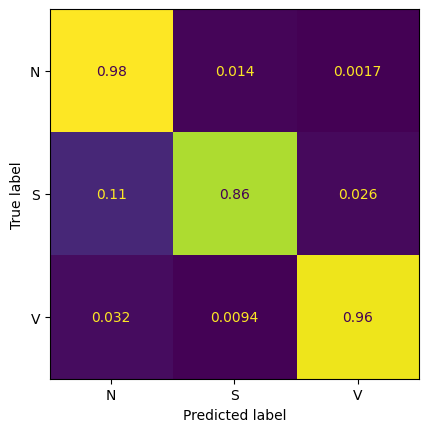

              precision    recall  f1-score   support

           0     0.9929    0.9847    0.9888     44005
           1     0.7156    0.8629    0.7824      1831
           2     0.9618    0.9582    0.9600      3203

    accuracy                         0.9784     49039
   macro avg     0.8901    0.9353    0.9104     49039
weighted avg     0.9806    0.9784    0.9792     49039

Time: 1413.85s; Balanced accuracy: 93.53%
N -> Precision: 99.29%±0.00; Recall: 98.47%±0.00; F1-score: 98.88%±0.00
V -> Precision: 96.18%±0.00; Recall: 95.82%±0.00; F1-score: 96.00%±0.00
S -> Precision: 71.56%±0.00; Recall: 86.29%±0.00; F1-score: 78.24%±0.00
Balanced accuracy: 93.53% ± 0.000000


In [27]:
callbacks = [
    #LRScheduler(policy=StepLR, step_size=20, gamma=.5),
    EpochScoring(scoring=make_scorer(f1_score, average="macro"), lower_is_better=False, name="valid_f1"),
    EpochScoring(scoring=make_scorer(balanced_accuracy_score), lower_is_better=False, name="valid_acc_bal"),
    Checkpoint(f_pickle='models/checkpoint.pkl', load_best=True, monitor='valid_acc_bal_best')
]

n_iterations = 1

n_features = 5
n_lt_features = 5

#class_weights = torch.from_numpy(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)).to(torch.float32).to(DEVICE)
#class_weights[2] = 2 * class_weights[0]
#class_weights[1] /= 6
#class_weights = torch.Tensor([1., 10., 5.]).to(torch.float32).to(DEVICE)
#class_weights = torch.Tensor([[1, 50, 10], [50, 50, 50], [10, 10, 10]]).to(torch.float32).to(DEVICE)
class_weights = None

reports = []
balanced_accuracies = []
predictions = []
for i in range(n_iterations):
    print(f"Iteration {i}")
    ts = time()
    model, report, bal_acc, y_true, y_pred = train_and_evaluate_model(
        X_cwt_train, rr_train, y_train, X_cwt_test, rr_test, y_test,
        X_feat_train=X_feat_train[:, :n_features], X_feat_test=X_feat_test[:, :n_features],
        #X_lt_feat_train=X_lt_feat_train[:, :n_lt_features], X_lt_feat_test=X_lt_feat_test[:, :n_lt_features],
        # X_oversampled, rr_oversampled, y_oversampled, X_cwt_test, rr_test, y_test,
        # X_feat_train=X_feat_oversampled[:, :n_features], X_feat_test=X_feat_test[:, :n_features],
        # X_lt_feat_train=X_lt_feat_oversampled[:, :n_lt_features], X_lt_feat_test=X_lt_feat_test[:, :n_lt_features],
        max_epochs=200, class_weights=class_weights, loss=torch.nn.CrossEntropyLoss, weight_decay=0, lr=1E-4, batch_size=4096,
        model_class=CNN2D, callbacks=callbacks, verbose=True, random_seed=i
    )
    balanced_accuracies.append(bal_acc)
    reports.append(report)
    predictions.append((y_true, y_pred))
    print(f"Time: {time() - ts:.02f}s; Balanced accuracy: {bal_acc * 100:.02f}%")
pkl.dump(predictions, open('results/experiment_3.pkl', 'wb'))
print_results(reports)
print(f"Balanced accuracy: {np.mean(balanced_accuracies) * 100:.02f}% ± {np.std(balanced_accuracies) * 100:02f}")

/tmp/ipykernel_5309/803835625.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, fontsize=15)
/tmp/ipykernel_5309/803835625.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels, fontsize=15)


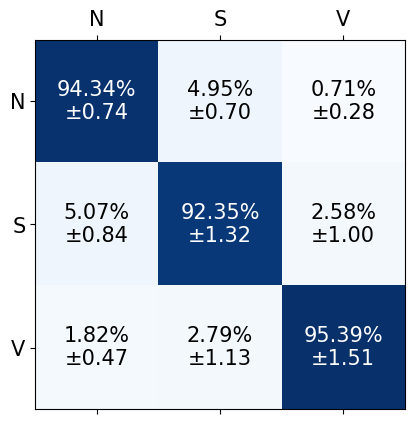

N -> Precision: 99.64%±0.05; Recall: 94.34%±0.74; F1-score: 96.92%±0.38
V -> Precision: 89.59%±3.59; Recall: 95.39%±1.51; F1-score: 92.35%±1.88
S -> Precision: 43.04%±3.49; Recall: 92.35%±1.32; F1-score: 58.62%±3.16
Balanced accuracy: 94.03% ± 0.64


In [74]:
results = pkl.load(open('results/experiment_1.pkl', 'rb'))
#results = pkl.load(open('results/experiment_2.pkl', 'rb'))
#results = pkl.load(open('results/experiment_3.pkl', 'rb'))

conf_matrices = []
for y_test, y_pred in results:
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_mat / np.expand_dims(conf_mat.sum(axis=1), axis=1))

# Calculate mean and standard deviation
conf_matrices = np.array(conf_matrices)
mean_conf_matrix = np.mean(conf_matrices, axis=0)
std_conf_matrix = np.std(conf_matrices, axis=0)



# Plotting
fig, ax = plt.subplots()
cax = ax.matshow(mean_conf_matrix, cmap=plt.cm.Blues)

color_threshold = mean_conf_matrix.max() / 2

for (i, j), val in np.ndenumerate(mean_conf_matrix):
    color = "white" if mean_conf_matrix[i, j] > color_threshold else "black"
    ax.text(j, i, f"{val:.2%}\n±{std_conf_matrix[i, j] * 100:.2f}", ha='center', va='center', color=color, fontsize=15)

labels = [num_to_label[i] for i in range(len(allowed_labels))]
ax.set_xticklabels([''] + labels, fontsize=15)
ax.set_yticklabels([''] + labels, fontsize=15)

#plt.savefig("figs/cm_result_1.pdf")
plt.show()

print_results([classification_report(y_true, y_pred, output_dict=True) for y_true, y_pred in results])
balanced_accuracies = [balanced_accuracy_score(y_true, y_pred) for y_true, y_pred in results]
print(f"Balanced accuracy: {np.mean(balanced_accuracies) * 100:.02f}% ± {(np.std(balanced_accuracies) * 100):.02f}")

/tmp/ipykernel_5309/908863573.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, fontsize=15)
/tmp/ipykernel_5309/908863573.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels, fontsize=15)


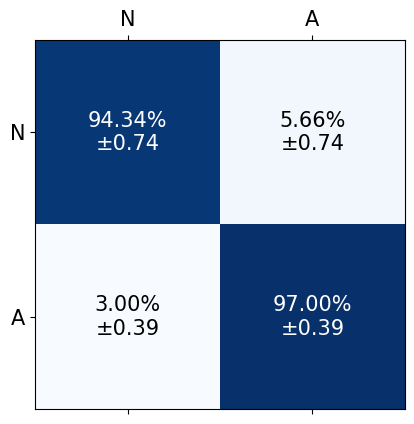

N -> Precision: 99.64%±0.05; Recall: 94.34%±0.74; F1-score: 96.92%±0.38
A -> Precision: 66.36%±2.88; Recall: 97.00%±0.39; F1-score: 78.76%±2.01
Balanced accuracy: 95.67% ± 0.37


In [75]:
results = pkl.load(open('results/experiment_1.pkl', 'rb'))
#results = pkl.load(open('results/experiment_2.pkl', 'rb'))
#results = pkl.load(open('results/experiment_3.pkl', 'rb'))

conf_matrices = []
filtered_results = []
for y_test, y_pred in results:
    y_pred = np.where(y_pred > 0, 1, y_pred)
    y_test = np.where(y_test > 0, 1, y_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_mat / np.expand_dims(conf_mat.sum(axis=1), axis=1))
    filtered_results.append((y_test, y_pred))

# Calculate mean and standard deviation
conf_matrices = np.array(conf_matrices)
mean_conf_matrix = np.mean(conf_matrices, axis=0)
std_conf_matrix = np.std(conf_matrices, axis=0)

# Plotting
fig, ax = plt.subplots()
cax = ax.matshow(mean_conf_matrix, cmap=plt.cm.Blues)

color_threshold = mean_conf_matrix.max() / 2

for (i, j), val in np.ndenumerate(mean_conf_matrix):
    color = "white" if mean_conf_matrix[i, j] > color_threshold else "black"
    ax.text(j, i, f"{val:.2%}\n±{std_conf_matrix[i, j] * 100:.2f}", ha='center', va='center', color=color, fontsize=15)

labels = ['N', 'A']
ax.set_xticklabels([''] + labels, fontsize=15)
ax.set_yticklabels([''] + labels, fontsize=15)

#plt.savefig("figs/cm_result_3_abnormal.pdf")
plt.show()

print_results([classification_report(y_true, y_pred, output_dict=True) for y_true, y_pred in filtered_results], num_to_label={0.: 'N', 1.: 'A'}, allowed_labels=(0, 1))
balanced_accuracies = [balanced_accuracy_score(y_true, y_pred) for y_true, y_pred in filtered_results]
print(f"Balanced accuracy: {np.mean(balanced_accuracies) * 100:.02f}% ± {(np.std(balanced_accuracies) * 100):.02f}")

/tmp/ipykernel_5309/1023430629.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, fontsize=15)
/tmp/ipykernel_5309/1023430629.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels, fontsize=15)


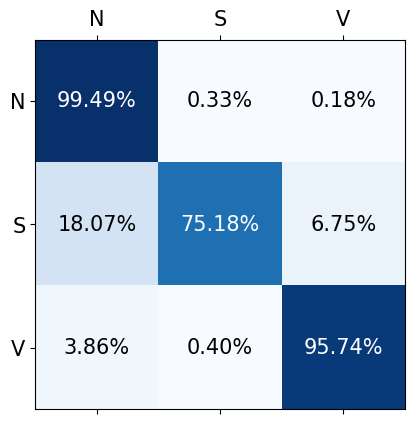

N -> Precision: 81.94%; Recall: 99.49%; F1-score: 89.87%
V -> Precision: 93.25%; Recall: 95.74%; F1-score: 94.48%
S -> Precision: 99.03%; Recall: 75.18%; F1-score: 85.47%
Balanced accuracy: 90.14%


In [86]:
cm = np.array([[43962, 147, 79], [329, 1369, 123], [124, 13, 3079]])
cm = cm / np.expand_dims(cm.sum(axis=1), axis=1)

fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)

color_threshold = cm.max() / 2

for (i, j), val in np.ndenumerate(cm):
    color = "white" if cm[i, j] > color_threshold else "black"
    ax.text(j, i, f"{val:.2%}", ha='center', va='center', color=color, fontsize=15)

labels = ['N', 'S', 'V']
ax.set_xticklabels([''] + labels, fontsize=15)
ax.set_yticklabels([''] + labels, fontsize=15)

#plt.savefig("figs/cm_result_original_abnormal.pdf")
plt.show()

class_recall = []
class_precision = []
class_f1_score = []
num_classes = cm.shape[0]

for i in range(num_classes):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score_i = 2 * precision_i * recall_i / (precision_i + recall_i) if (precision_i + recall_i) != 0 else 0
    class_recall.append(recall_i)
    class_precision.append(precision_i)
    class_f1_score.append(f1_score_i)


for label in [0, 2, 1]:
    print(f"{num_to_label[label]} -> Precision: {np.mean(class_precision[label]):.02%}; Recall: {np.mean(class_recall[label]):.02%}; F1-score: {np.mean(class_f1_score[label]):.02%}")
print(f"Balanced accuracy: {np.mean(class_recall):.02%}")

/tmp/ipykernel_5309/155468662.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels, fontsize=15)
/tmp/ipykernel_5309/155468662.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels, fontsize=15)


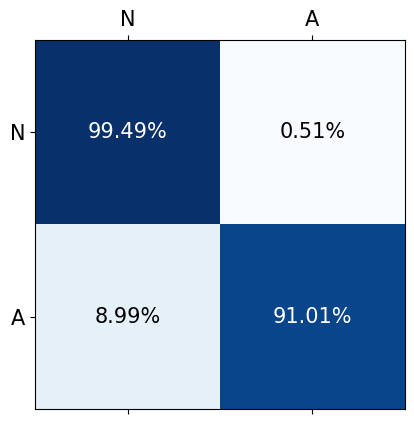

N -> Precision: 91.71%; Recall: 99.49%; F1-score: 95.44%
S -> Precision: 99.44%; Recall: 91.01%; F1-score: 95.04%
Balanced accuracy: 95.25%


In [84]:
cm = np.array([[43962, 147 + 79], [329 + 124, 1369 + 123 + 13 + 3079]])
cm = cm / np.expand_dims(cm.sum(axis=1), axis=1)

fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)

color_threshold = cm.max() / 2

for (i, j), val in np.ndenumerate(cm):
    color = "white" if cm[i, j] > color_threshold else "black"
    ax.text(j, i, f"{val:.2%}", ha='center', va='center', color=color, fontsize=15)

labels = ['N', 'A']
ax.set_xticklabels([''] + labels, fontsize=15)
ax.set_yticklabels([''] + labels, fontsize=15)

#plt.savefig("figs/cm_result_original_abnormal.pdf")
plt.show()

class_recall = []
class_precision = []
class_f1_score = []
num_classes = cm.shape[0]

for i in range(num_classes):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score_i = 2 * precision_i * recall_i / (precision_i + recall_i) if (precision_i + recall_i) != 0 else 0
    class_recall.append(recall_i)
    class_precision.append(precision_i)
    class_f1_score.append(f1_score_i)


for label in [0, 1]:
    print(f"{num_to_label[label]} -> Precision: {np.mean(class_precision[label]):.02%}; Recall: {np.mean(class_recall[label]):.02%}; F1-score: {np.mean(class_f1_score[label]):.02%}")
print(f"Balanced accuracy: {np.mean(class_recall):.02%}")

In [ ]:
class_recall = []
num_classes = conf_matrix.shape[0]

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    class_recall.append(recall_i)

balanced_accuracy = np.mean(class_recall)
